## Project in Statistical Methods for Data Science

#### By Thea Törnqvist

#### Importing necessary modules 

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score


### 1) Importing datasets and merging 

In [2]:
# All CSV-files in the same folder 
folder_path = "C://Users/theat/Downloads/archive1"

# Empty dictionary to store datasets
datasets = {}

# Reads all CSV-files in folder
for file in os.listdir(folder_path):
    if file.endswith('.csv') and not file.startswith('.'):
        # Creates key for the dict based on the filename
        dataset_name = os.path.splitext(file)[0]
        datasets[dataset_name] = pd.read_csv(os.path.join(folder_path, file))

# Print the datasets to see they were read correctly
for name, df in datasets.items():
    print(f"Dataset: {name}")
    print(df.head())

Dataset: Customer_Info
  customer_id  gender  age under_30 senior_citizen partner dependents  \
0  0002-ORFBO  Female   37       No             No     Yes         No   
1  0003-MKNFE    Male   46       No             No      No         No   
2  0004-TLHLJ    Male   50       No             No      No         No   
3  0011-IGKFF    Male   78       No            Yes     Yes         No   
4  0013-EXCHZ  Female   75       No            Yes     Yes         No   

   number_of_dependents married  
0                     0     Yes  
1                     0      No  
2                     0      No  
3                     0     Yes  
4                     0     Yes  
Dataset: Location_Data
  customer_id        country       state          city  zip_code  \
0  0002-ORFBO  United States  California  Frazier Park     93225   
1  0003-MKNFE  United States  California      Glendale     91206   
2  0004-TLHLJ  United States  California    Costa Mesa     92627   
3  0011-IGKFF  United States  Californi

#### 1.1 Merging datasets

In [3]:
# Starting with customer_info as the "base dataset" 
merged_data = datasets['Customer_Info']

# Iterate through the other datasets and merge them
for name, df in datasets.items():
    if name != 'Customer_Info': # Skip the base dataset
        merged_data = merged_data.merge(df, on='customer_id', how='inner')  

# Removing and renaming duplicate columns after seeing they are identical
merged_data = merged_data.drop(columns=['phone_service_y', 'internet_service_y'])
merged_data = merged_data.rename(columns={
    'phone_service_x': 'phone_service',
    'internet_service_x': 'internet_service'
})

# Printing to see if the merged dataset looks correct
merged_data.info() 
merged_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        7043 non-null   object 
 1   gender                             7043 non-null   object 
 2   age                                7043 non-null   int64  
 3   under_30                           7043 non-null   object 
 4   senior_citizen                     7043 non-null   object 
 5   partner                            7043 non-null   object 
 6   dependents                         7043 non-null   object 
 7   number_of_dependents               7043 non-null   int64  
 8   married                            7043 non-null   object 
 9   country                            7043 non-null   object 
 10  state                              7043 non-null   object 
 11  city                               7043 non-null   objec

,customer_id,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,married,country,...,referred_a_friend,number_of_referrals,satisfaction_score,cltv,customer_status,churn_score,churn_label,churn_value,churn_category,churn_reason
0,0002-ORFBO,Female,37,No,No,Yes,No,0,Yes,United States,...,Yes,2,3,2205,Stayed,65,No,0,Not Applicable,NaN
1,0003-MKNFE,Male,46,No,No,No,No,0,No,United States,...,No,0,5,5414,Stayed,66,No,0,Not Applicable,NaN
2,0004-TLHLJ,Male,50,No,No,No,No,0,No,United States,...,No,0,1,4479,Churned,71,Yes,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,No,Yes,Yes,No,0,Yes,United States,...,Yes,1,1,3714,Churned,91,Yes,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,No,Yes,Yes,No,0,Yes,United States,...,Yes,3,1,3464,Churned,68,Yes,1,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,Yes,No,No,No,0,No,United States,...,No,0,4,3161,Stayed,59,No,0,Not Applicable,NaN
7039,9992-RRAMN,Male,40,No,No,Yes,No,0,Yes,United States,...,Yes,1,1,5248,Churned,68,Yes,1,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,Yes,No,No,No,0,No,United States,...,No,0,5,5870,Joined,33,No,0,Not Applicable,NaN
7041,9993-LHIEB,Male,21,Yes,No,Yes,No,0,Yes,United States,...,Yes,5,3,4792,Stayed,59,No,0,Not Applicable,NaN


### 2) Visualization and descriptive statistics

#### 2.1 Descriptive statistics

In [4]:
# Firstly some descriptive statistics for the merged dataset
num_variables = ['age', 'tenure', 'total_population', 'satisfaction_score', 'total_charges']

merged_data[num_variables].describe()

,age,tenure,total_population,satisfaction_score,total_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,32.371149,22139.814568,3.244924,2280.381264
std,16.750352,24.559481,21152.174407,1.201657,2266.220462
min,19.000000,0.000000,11.000000,1.000000,18.800000
25%,32.000000,9.000000,2344.000000,3.000000,400.150000
50%,46.000000,29.000000,17554.000000,3.000000,1394.550000
75%,60.000000,55.000000,36125.000000,4.000000,3786.600000
max,80.000000,72.000000,105285.000000,5.000000,8684.800000


#### 2.2 Demographic and geographic variables 

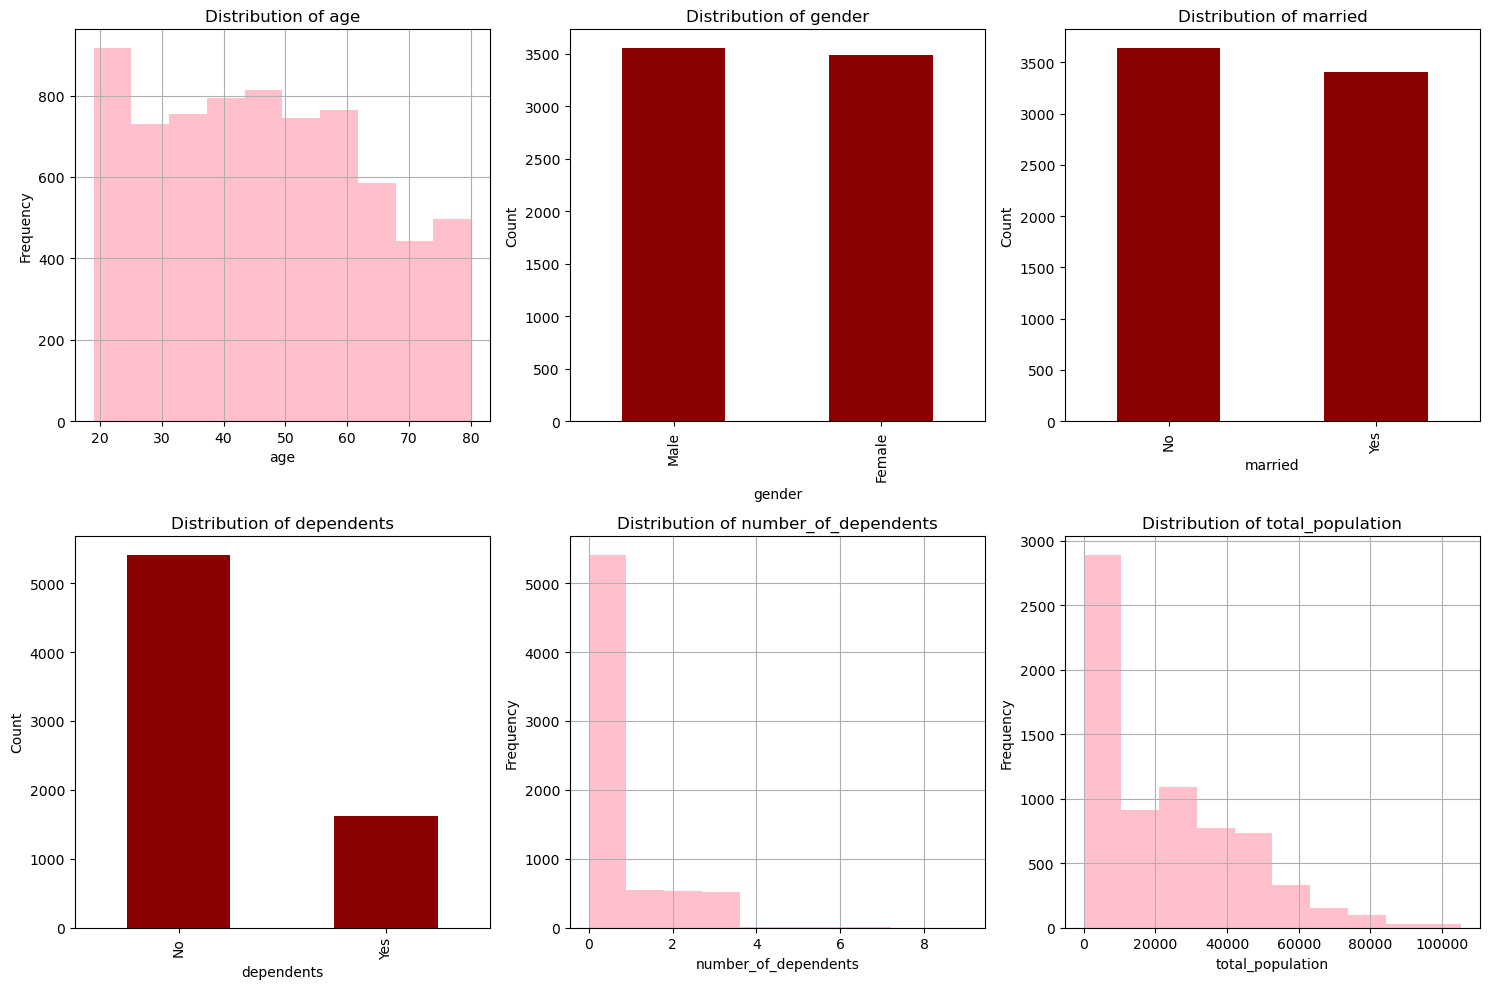

In [5]:
# Variables to visualize
variables = ['age', 'gender', 'married', 'dependents', 'number_of_dependents', 'total_population']

# Creating a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Iterate through variables and create a plot for each
for i, var in enumerate(variables):
    ax = axes[i // 3, i % 3]  # Calculates which row and column every variable should be placed on
    if merged_data[var].dtype == 'object': # If categorical variable
        merged_data[var].value_counts().plot(kind='bar', ax=ax, color='darkred')
        ax.set_title(f'Distribution of {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Count')
    else:  # If numerical variable
        merged_data[var].hist(ax=ax, bins=10, color='pink')
        ax.set_title(f'Distribution of {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Frequency')

# To avoid overlapping
plt.tight_layout()
plt.show()


#### 2.3 Service subscription

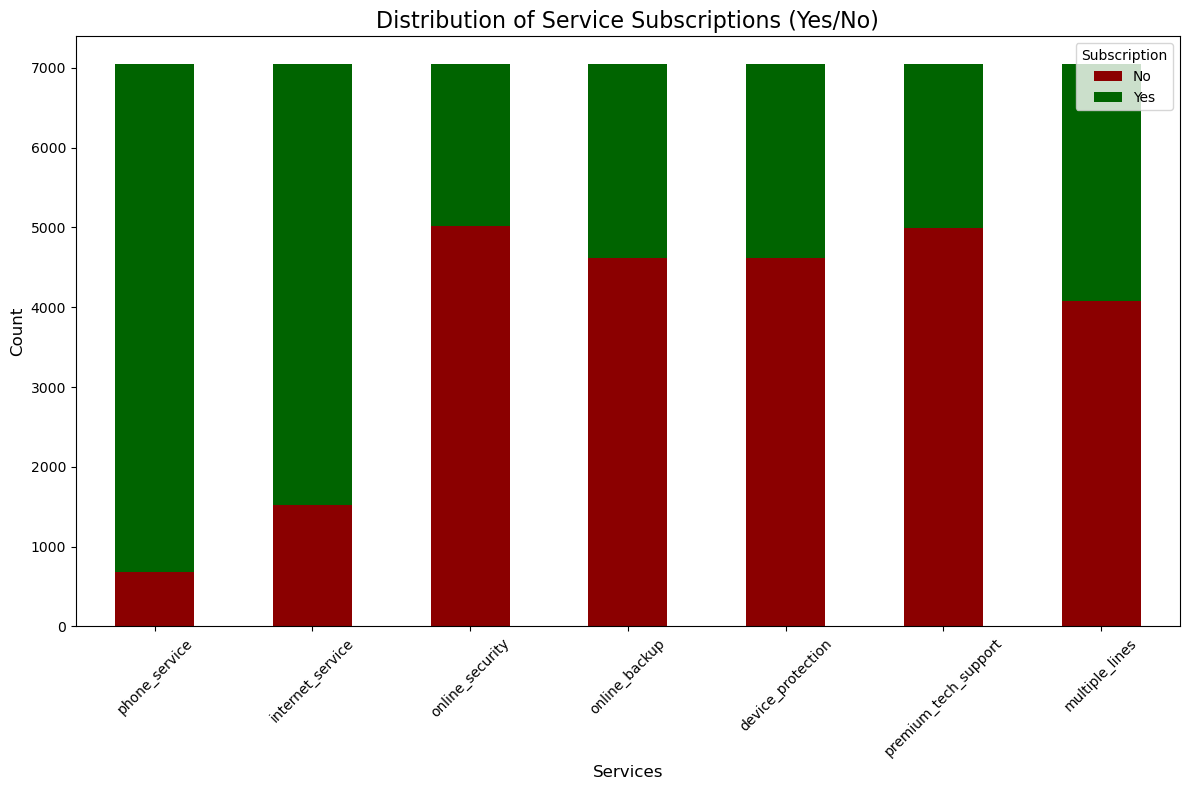

In [6]:
# Service variables I want to visualize
service_variables = [
    'phone_service', 'internet_service', 'online_security',
    'online_backup', 'device_protection', 'premium_tech_support', 'multiple_lines'
]

# Prepare data for visualization
service_data = merged_data[service_variables].apply(lambda x: x.value_counts()).T
service_data.columns = ['No', 'Yes']

# Create a staple plot
service_data.plot(kind='bar', stacked=True, color=['darkred', 'darkgreen'], figsize=(12, 8))

# Adjust the diagram
plt.title('Distribution of Service Subscriptions (Yes/No)', fontsize=16)
plt.xlabel('Services', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Subscription', loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


#### 2.4 Payment behavior

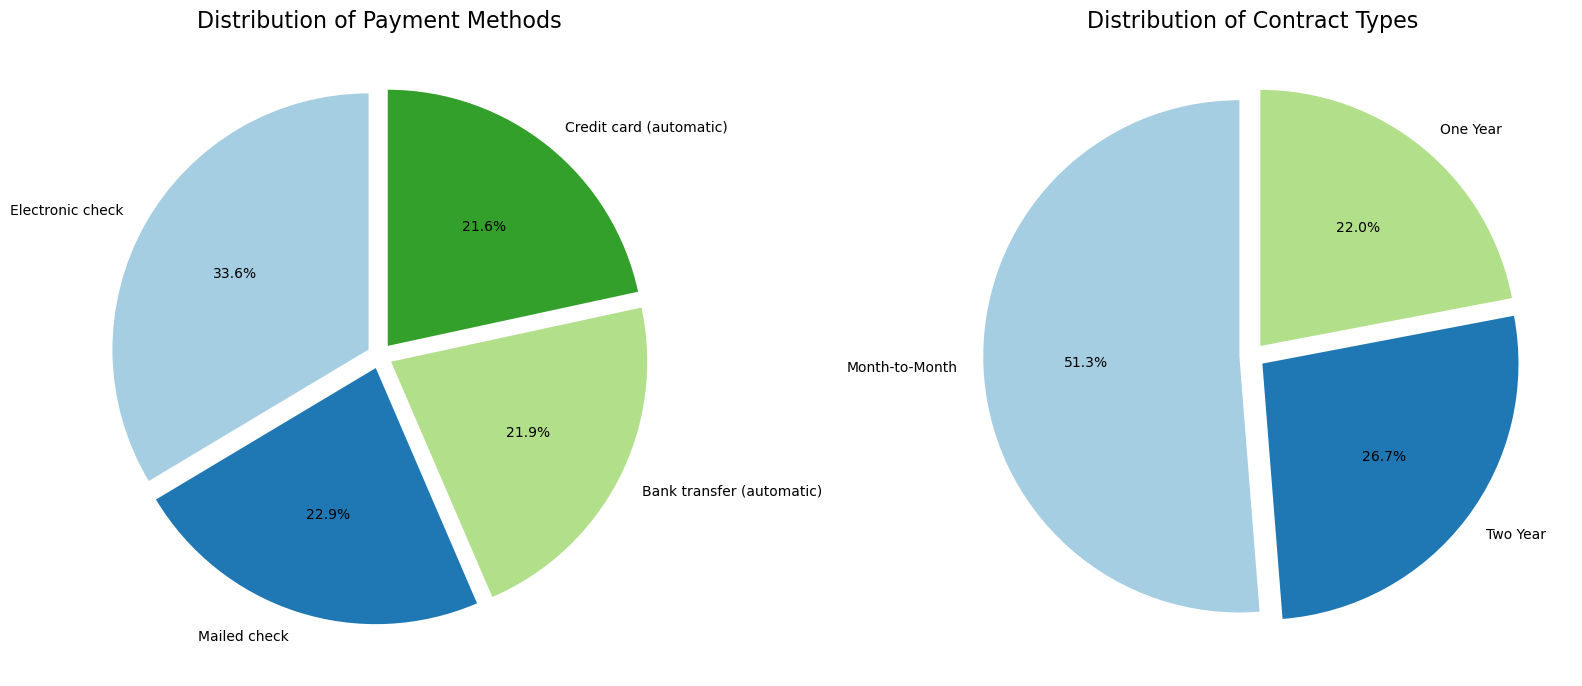

In [7]:
# Count occurrences of each payment method and contract type
payment_method_counts = merged_data['payment_method'].value_counts()
contract_counts = merged_data['contract'].value_counts()

# Create a 1x2 grid for the pie charts
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart for Payment Methods
payment_method_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors,
    explode=[0.05] * len(payment_method_counts),
    ax=axes[0]
)
axes[0].set_title('Distribution of Payment Methods', fontsize=16)
axes[0].set_ylabel('')  # Remove y-axis label for cleaner look

# Pie chart for Contract Types
contract_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors,
    explode=[0.05] * len(contract_counts),
    ax=axes[1]
)
axes[1].set_title('Distribution of Contract Types', fontsize=16)
axes[1].set_ylabel('')  # Remove y-axis label for cleaner look

# Adjust layout
plt.tight_layout()
plt.show()


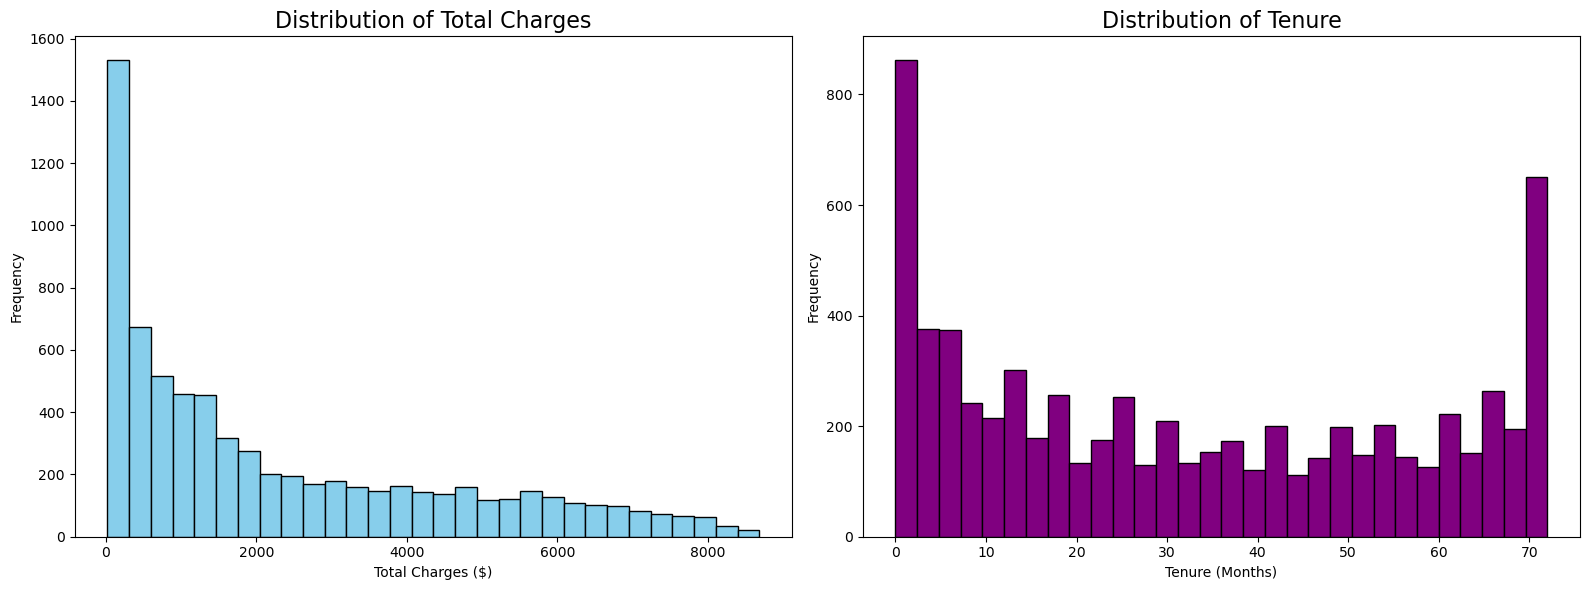

In [8]:
# Create a 1x2 grid for Total Charges and Tenure histograms
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram for Total Charges
axes[0].hist(merged_data['total_charges'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Total Charges', fontsize=16)
axes[0].set_xlabel('Total Charges ($)')
axes[0].set_ylabel('Frequency')

# Histogram for Tenure
axes[1].hist(merged_data['tenure'], bins=30, color='purple', edgecolor='black')
axes[1].set_title('Distribution of Tenure', fontsize=16)
axes[1].set_xlabel('Tenure (Months)')
axes[1].set_ylabel('Frequency')

# Adjusting layout
plt.tight_layout()
plt.show()


#### 2.5 Churn analysis

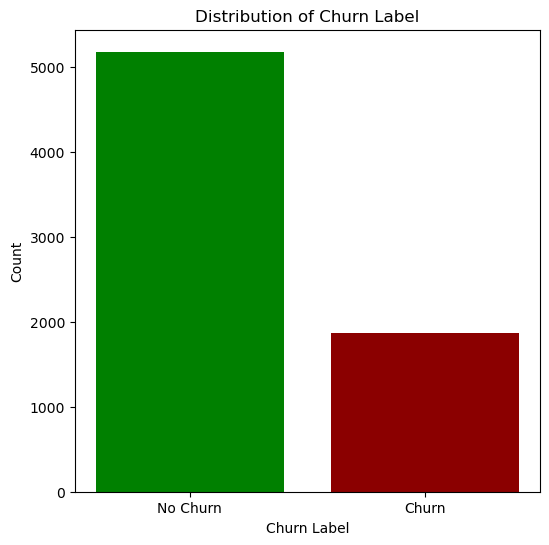

In [9]:
# Count the occurrences of each churn label
churn_counts = merged_data['churn_value'].value_counts()

# Plotting the churn label distribution
plt.figure(figsize=(6, 6))
plt.bar(churn_counts.index.map({0: 'No Churn', 1: 'Churn'}), churn_counts.values, color=['green', 'darkred'])
plt.title('Distribution of Churn Label')
plt.xlabel('Churn Label')
plt.ylabel('Count')
plt.show()


### 4) Statistical Analysis

#### Hypothesis 1: Contract type vs. churn 

In [10]:
# Contingency table
contingency_table = pd.crosstab(merged_data['contract'], merged_data['churn_label'])
print(contingency_table)

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

churn_label       No   Yes
contract                  
Month-to-Month  1955  1655
One Year        1384   166
Two Year        1835    48
Chi-square statistic: 1445.2932428377585
P-value: 0.0


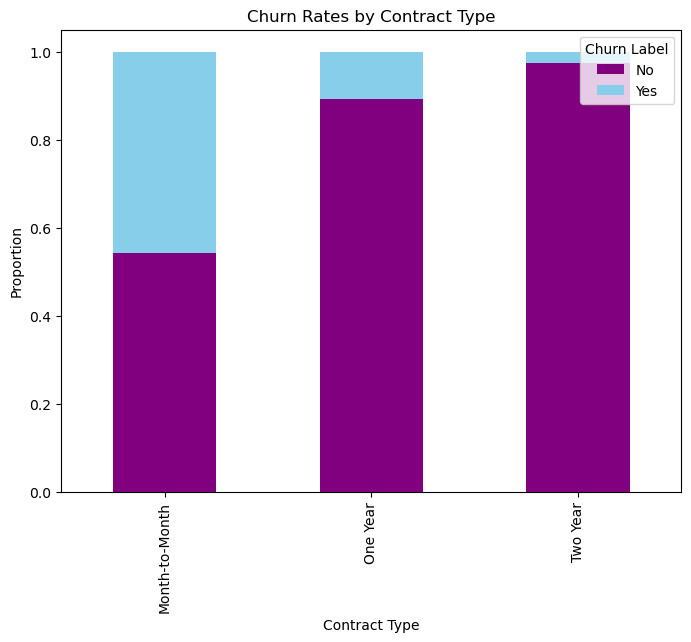

In [11]:
# Visualize contract type and churn label in barplot
churn_rates = merged_data.groupby('contract')['churn_label'].value_counts(normalize=True).unstack()
churn_rates.plot(kind='bar', stacked=True, figsize=(8, 6), color=['purple', 'skyblue'])
plt.title('Churn Rates by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Proportion')

plt.legend(title='Churn Label', loc='upper right')
plt.show()

#### Hypothesis 2: Churn rate vs. urban/suburban/rural

In [12]:
# Create function to categorize the total_population variable
def categorize_population(x):
    if x < 10000:
        return 'Rural'
    elif x < 50000:
        return 'Suburban'
    else:
        return 'Urban'

# Apply the categorization
merged_data['area_type'] = merged_data['total_population'].apply(categorize_population)

# Check the distribution of the categories
print(merged_data['area_type'].value_counts())


area_type
Suburban    3469
Rural       2846
Urban        728
Name: count, dtype: int64


In [13]:
# Create a contingency table
contingency_table = pd.crosstab(merged_data['area_type'], merged_data['churn_label'], margins=True)
print(contingency_table)

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table.iloc[:-1, :-1])
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

churn_label    No   Yes   All
area_type                    
Rural        2152   694  2846
Suburban     2514   955  3469
Urban         508   220   728
All          5174  1869  7043
Chi-square statistic: 13.577997522373304
P-value: 0.0011260957006424624


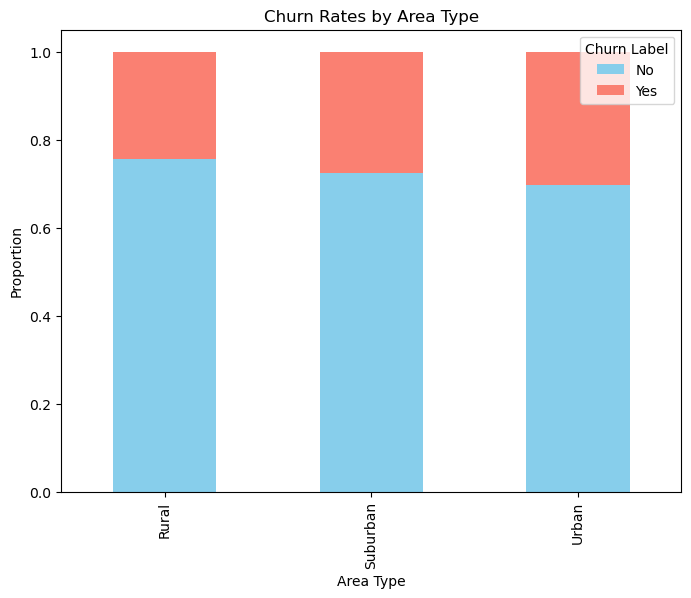

In [14]:
# Calculate churn rates by area type
churn_rates = merged_data.groupby('area_type')['churn_label'].value_counts(normalize=True).unstack()

# Plotting the relationship
churn_rates.plot(kind='bar', stacked=True, figsize=(8, 6), color=['skyblue', 'salmon'])
plt.title('Churn Rates by Area Type')
plt.xlabel('Area Type')
plt.ylabel('Proportion')
plt.legend(title='Churn Label', loc='upper right')
plt.show()


#### Hypothesis 3: Number of services vs. churn rate

In [15]:
# Calculate the number of services for each customer
service_columns = ['phone_service', 'internet_service', 'online_security', 'online_backup',
                   'device_protection', 'premium_tech_support', 'multiple_lines']
merged_data['num_services'] = merged_data[service_columns].apply(lambda x: (x == 'Yes').sum(), axis=1)

# Split data based on churn_value
churned = merged_data[merged_data['churn_value'] == 1]['num_services']
not_churned = merged_data[merged_data['churn_value'] == 0]['num_services']

# Perform Welch's t-test
t_stat, p_val = ttest_ind(churned, not_churned, equal_var=False)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")


T-statistic: -5.954343045322362
P-value: 2.8040334114386776e-09


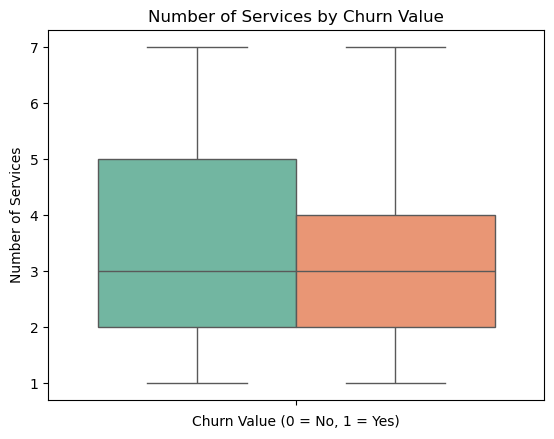

In [16]:
# Visualizing the relationship
sns.boxplot(hue='churn_value', y='num_services', data=merged_data, palette='Set2', legend=False)
plt.title('Number of Services by Churn Value')
plt.xlabel('Churn Value (0 = No, 1 = Yes)')
plt.ylabel('Number of Services')
plt.show()


## 5) Machine learning predictions

#### Step 1: Train-test split

In [17]:
# Define the selected features and the target variable
selected_features = ['num_services', 'contract', 'area_type', 'tenure', 'dependents', 'internet_type', 'senior_citizen']

X = merged_data[selected_features]
y = merged_data['churn_value']  

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      
    random_state=42,    
    stratify=y          
)

# Check the shape of the datasets to confirm the split 
print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (5634, 7)
Testing shape: (1409, 7)


In [18]:
X_train # To double-check that it looks correct

,num_services,contract,area_type,tenure,dependents,internet_type,senior_citizen
3793,5,Month-to-Month,Rural,60,No,Fiber Optic,No
3192,1,Two Year,Suburban,12,Yes,NaN,No
4922,4,Month-to-Month,Rural,2,No,Fiber Optic,No
3926,4,One Year,Suburban,33,No,Cable,No
3859,5,Month-to-Month,Rural,14,Yes,Fiber Optic,No
...,...,...,...,...,...,...,...
6331,1,One Year,Suburban,22,Yes,NaN,No
6146,3,Month-to-Month,Rural,42,No,Fiber Optic,No
4485,3,Month-to-Month,Suburban,20,No,Fiber Optic,No
2739,2,Two Year,Rural,24,Yes,NaN,No


#### Step 2: Encoding

In [19]:
# Split up the binary and multi-categorical features
binary_cols = ['dependents', 'senior_citizen']
multi_cols = ['contract', 'area_type', 'internet_type']

# LabelEncoder for binary features
le = LabelEncoder()
for col in binary_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])  # Only transform on test data

# OneHotEncoder for multi-categorical features
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on training data and transform on both test and train
ohe_train = ohe.fit_transform(X_train[multi_cols])
ohe_test = ohe.transform(X_test[multi_cols])

# Create dataframes with the right column labels
ohe_cols = ohe.get_feature_names_out(multi_cols)
ohe_train_df = pd.DataFrame(ohe_train, columns=ohe_cols, index=X_train.index)
ohe_test_df = pd.DataFrame(ohe_test, columns=ohe_cols, index=X_test.index)

# Merge the encoded columns with reamining data
X_train = pd.concat([X_train.drop(columns=multi_cols), ohe_train_df], axis=1)
X_test = pd.concat([X_test.drop(columns=multi_cols), ohe_test_df], axis=1)

# Check the encoding 
X_train


,num_services,tenure,dependents,senior_citizen,contract_Month-to-Month,contract_One Year,contract_Two Year,area_type_Rural,area_type_Suburban,area_type_Urban,internet_type_Cable,internet_type_DSL,internet_type_Fiber Optic,internet_type_nan
3793,5,60,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3192,1,12,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4922,4,2,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3926,4,33,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3859,5,14,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,1,22,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6146,3,42,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4485,3,20,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2739,2,24,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
# To check that the shape remained after encoding
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Checking that we now only have int or float values
print(X_train.dtypes.value_counts())

# Checking all the columns 
print(X_train.columns)

# Making sure the sum of columns are 0
print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

# Checks so that it is a pandas dataframe for the scaling part
print(type(X_train))
print(type(X_test))

X_train shape: (5634, 14)
X_test shape: (1409, 14)
float64    10
int64       2
int32       2
Name: count, dtype: int64
Index(['num_services', 'tenure', 'dependents', 'senior_citizen',
       'contract_Month-to-Month', 'contract_One Year', 'contract_Two Year',
       'area_type_Rural', 'area_type_Suburban', 'area_type_Urban',
       'internet_type_Cable', 'internet_type_DSL', 'internet_type_Fiber Optic',
       'internet_type_nan'],
      dtype='object')
0
0
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### Step 3: Scaling

In [21]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform while keeping the DataFrame structure
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Double-check the data again
X_train

,num_services,tenure,dependents,senior_citizen,contract_Month-to-Month,contract_One Year,contract_Two Year,area_type_Rural,area_type_Suburban,area_type_Urban,internet_type_Cable,internet_type_DSL,internet_type_Fiber Optic,internet_type_nan
3793,0.932505,1.124891,-0.550692,-0.438325,0.977186,-0.531502,-0.605377,1.213316,-0.984850,-0.339089,-0.366451,-0.552608,1.143296,-0.522154
3192,-1.369492,-0.827880,1.815897,-0.438325,-1.023347,-0.531502,1.651865,-0.824187,1.015383,-0.339089,-0.366451,-0.552608,-0.874664,1.915143
4922,0.357006,-1.234707,-0.550692,-0.438325,0.977186,-0.531502,-0.605377,1.213316,-0.984850,-0.339089,-0.366451,-0.552608,1.143296,-0.522154
3926,0.357006,0.026457,-0.550692,-0.438325,-1.023347,1.881459,-0.605377,-0.824187,1.015383,-0.339089,2.728878,-0.552608,-0.874664,-0.522154
3859,0.932505,-0.746514,1.815897,-0.438325,0.977186,-0.531502,-0.605377,1.213316,-0.984850,-0.339089,-0.366451,-0.552608,1.143296,-0.522154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,-1.369492,-0.421052,1.815897,-0.438325,-1.023347,1.881459,-0.605377,-0.824187,1.015383,-0.339089,-0.366451,-0.552608,-0.874664,1.915143
6146,-0.218494,0.392602,-0.550692,-0.438325,0.977186,-0.531502,-0.605377,1.213316,-0.984850,-0.339089,-0.366451,-0.552608,1.143296,-0.522154
4485,-0.218494,-0.502418,-0.550692,-0.438325,0.977186,-0.531502,-0.605377,-0.824187,1.015383,-0.339089,-0.366451,-0.552608,1.143296,-0.522154
2739,-0.793993,-0.339687,1.815897,-0.438325,-1.023347,-0.531502,1.651865,1.213316,-0.984850,-0.339089,-0.366451,-0.552608,-0.874664,1.915143


## Step 4: Train Models

### Naive Bayes

In [22]:
# Initialize and train the model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions
nb_preds = nb_model.predict(X_test)

# Evaluate the model
print("Naive Bayes Performance:")
print(classification_report(y_test, nb_preds))
print("Accuracy:", accuracy_score(y_test, nb_preds))


Naive Bayes Performance:
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1035
           1       0.54      0.77      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.76      0.78      1409

Accuracy: 0.7643718949609652


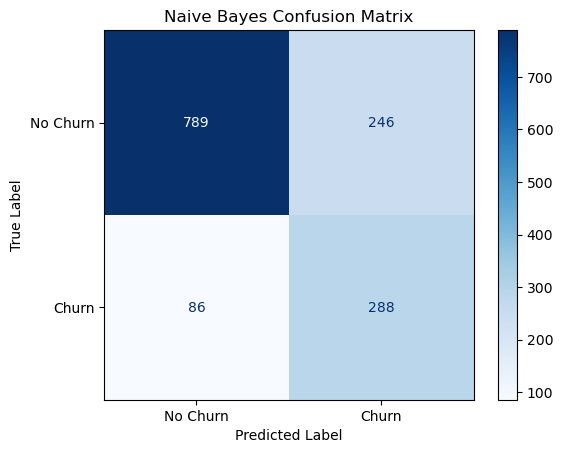

In [23]:
# Generate the confusion matrix
nb_cm = confusion_matrix(y_test, nb_preds)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues')

plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Logistic Regression

In [24]:
# Initialize and train the model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)

# Make predictions
log_reg_preds = log_reg_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Performance:")
print(classification_report(y_test, log_reg_preds))
print("Accuracy:", accuracy_score(y_test, log_reg_preds))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1035
           1       0.65      0.62      0.64       374

    accuracy                           0.81      1409
   macro avg       0.76      0.75      0.75      1409
weighted avg       0.81      0.81      0.81      1409

Accuracy: 0.8112136266855926


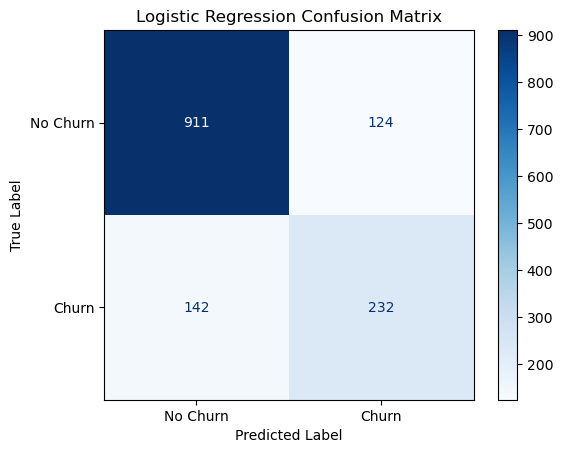

In [25]:
# Generate the confusion matrix
log_reg_cm = confusion_matrix(y_test, log_reg_preds)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=log_reg_cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues')

plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


C:\Users\theat\AppData\Local\Temp\ipykernel_21556\1691685081.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=log_reg_coefficients_sorted.values, y=log_reg_coefficients_sorted.index, palette="viridis")


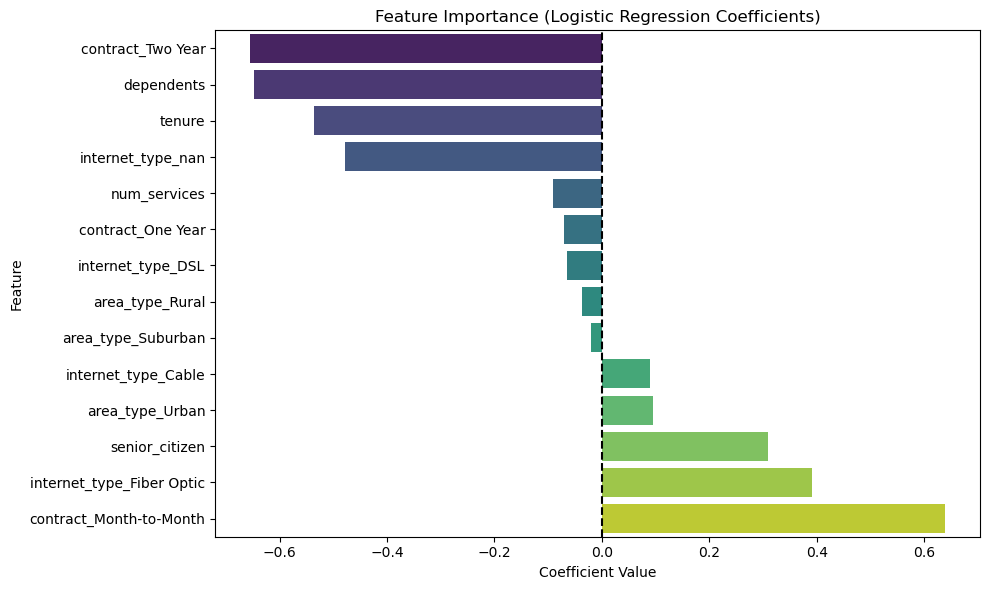

In [26]:
# Extract coefficients
log_reg_coefficients = pd.Series(log_reg_model.coef_[0], index=X_train.columns)

# Sort by absolute value to highlight importance
log_reg_coefficients_sorted = log_reg_coefficients.sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=log_reg_coefficients_sorted.values, y=log_reg_coefficients_sorted.index, palette="viridis")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(0, color='black', linestyle='--')  # Add a line at 0 for reference
plt.tight_layout()
plt.show()


### Decision Tree

In [27]:
# Initialize and train the model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
dt_preds = dt_model.predict(X_test)

# Evaluate the model
print("Decision Tree Performance:")
print(classification_report(y_test, dt_preds))
print("Accuracy:", accuracy_score(y_test, dt_preds))


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1035
           1       0.57      0.52      0.55       374

    accuracy                           0.77      1409
   macro avg       0.70      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409

Accuracy: 0.7700496806245565


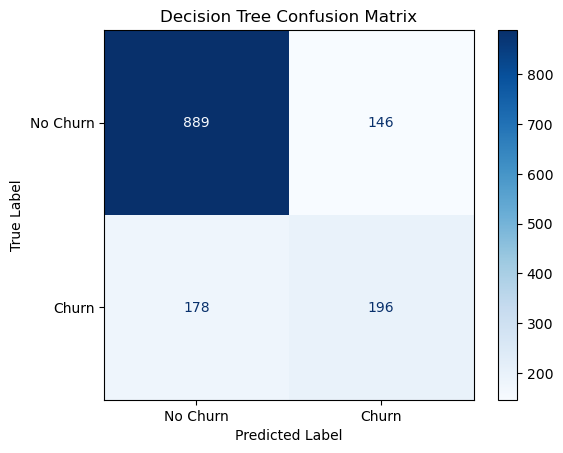

In [28]:
# Generate the confusion matrix for Decision Tree
dt_cm = confusion_matrix(y_test, dt_preds)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues')

plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


C:\Users\theat\AppData\Local\Temp\ipykernel_21556\3872832633.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dt_importance_sorted.values, y=dt_importance_sorted.index, palette="viridis")


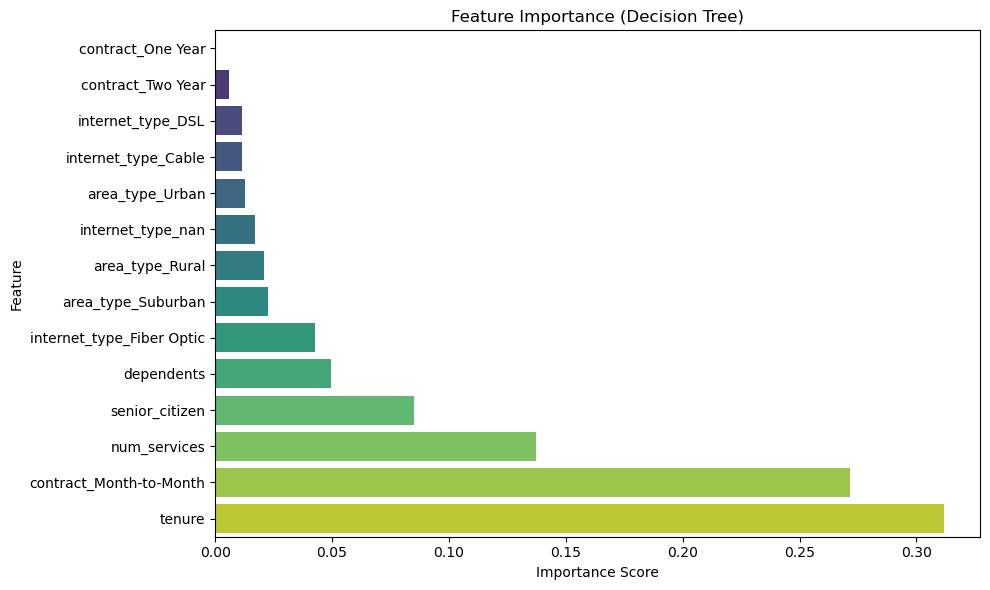

In [29]:
# Extract feature importance
dt_importance = pd.Series(dt_model.feature_importances_, index=X_train.columns)

# Sort and plot
dt_importance_sorted = dt_importance.sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=dt_importance_sorted.values, y=dt_importance_sorted.index, palette="viridis")
plt.title("Feature Importance (Decision Tree)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### ROC and AUC

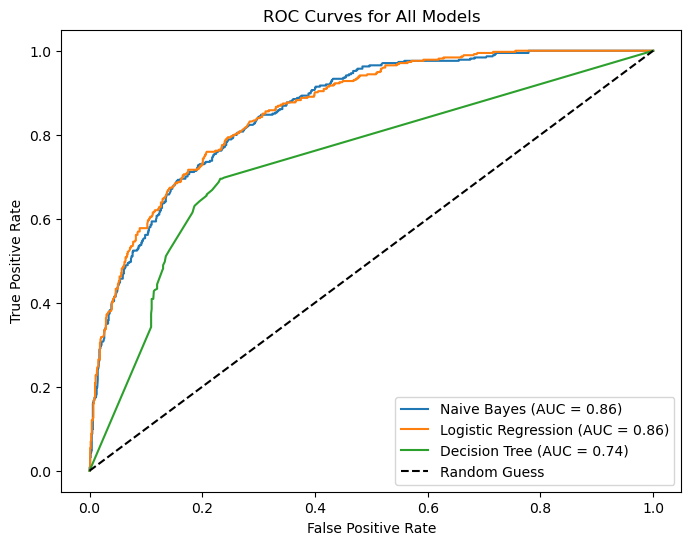

In [30]:
# Naive Bayes Probabilities
nb_probs = nb_model.predict_proba(X_test)[:, 1]

# Logistic Regression Probabilities
log_reg_probs = log_reg_model.predict_proba(X_test)[:, 1]

# Decision Tree Probabilities
dt_probs = dt_model.predict_proba(X_test)[:, 1]

# ROC Curves
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)

# AUC Scores
nb_auc = roc_auc_score(y_test, nb_probs)
log_reg_auc = roc_auc_score(y_test, log_reg_probs)
dt_auc = roc_auc_score(y_test, dt_probs)

# Plotting the ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})')
plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {log_reg_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})')

# Random Guess Line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()
